#![Text Mining Banner](https://cloud.githubusercontent.com/assets/1695067/8930792/23f23896-3531-11e5-850f-0e70679b8cbb.jpg)  ![Python Logo](https://cloud.githubusercontent.com/assets/1695067/8930654/f6bbe4e0-352f-11e5-8c42-507e27294f09.png) 
# **Text Mining and Analysis**
# Lab 8 - Analyzing Geographic and Institutional Data

####


#### **During this lab we will cover:**
#### *Part 1:* Networks
#### *Part 2:* Geovisualization

In [3]:
import json

fn = r'../../Data/JSON/full_nano_JSON.txt'
with open(fn, 'r') as fh:
    corpus = json.load(fh)

## Part 1: Networks

####A very powerful technique for visualization and analysis in techmining is network based. We can extract information on collaboration patterns and study these using social network analysis. There is also a long tradition to study citation network. In this chapter we are going to do both citation network and collaboration networks. We start with citations networks and will study this using the networkx library. We will also analyse collaboration patterns and demonstrate how we can visualize this on a world map. 


In [4]:
cr = list(corpus.values())[25000]['CR']
cr = cr.split('; ')
for entry in cr[0::2]:
    print(entry)

Armbrust EV, 2004, SCIENCE, V306, P79, DOI 10.1126/science.1101156
Bowler C, 2008, NATURE, V456, P239, DOI 10.1038/nature07410
Chepurnov VA, 2004, INT REV CYTOL, V237, P91, DOI 10.1016/S0074-7696(04)37003-8
De Riso V, 2009, NUCLEIC ACIDS RES, V37, DOI 10.1093/nar/gkp448
Field CB, 1998, SCIENCE, V281, P237, DOI 10.1126/science.281.5374.237
Gordon R, 2009, TRENDS BIOTECHNOL, V27, P116, DOI 10.1016/j.tibtech.2008.11.003
Kroger N, 2008, ANNU REV GENET, V42, P83, DOI 10.1146/annurev.genet.41.110306.130109
Lommer M, 2012, GENOME BIOL, V13, DOI 10.1186/gb-2012-13-7-r66
Nassif N., 2010, CHEM SOC REV, V40, P849
Tirichine L, 2014, MAR GENOM, V16, P67, DOI 10.1016/j.margen.2014.05.003
Trentacoste EM, 2013, P NATL ACAD SCI USA, V110, P19748, DOI 10.1073/pnas.1309299110
Xu B, 2014, MAR GENOM, V16, P29, DOI 10.1016/j.margen.2013.12.005
Zhang CY, 2014, MAR GENOM, V16, P63, DOI 10.1016/j.margen.2013.10.003


####If we look at the list of references above, we see that it is not entirely clean data. Sometimes, the name of the first author is in all caps, sometimes only the first letter is capitalized. Similarly, sometimes the first name of the author is given, in other cases initials are used. Also, for many articles we do have the document object identifier, but not for all. Sometimes volume information is given sometimes not, the same is true for issue information and page numbers. This makes cleaning citations a messy business. 

####For now, we take a rather simple approach. We are only going to use the author and the year and ignore the rest of the citation. We are also going to force the author name to lower case. 

In [10]:
for entry in cr[0::2]:
    author, year = entry.split(', ')[0:2]
    author = author.lower()
    print(author, year)

armbrust ev 2004
bowler c 2008
chepurnov va 2004
de riso v 2009
field cb 1998
gordon r 2009
kroger n 2008
lommer m 2012
nassif n. 2010
tirichine l 2014
trentacoste em 2013
xu b 2014
zhang cy 2014


####This cleans up the data considerably. We now see that there are some cases where there is a point after the initials. Let's remove these as well to be more consistent.

In [11]:
for entry in cr[0::2]:
    author, year = entry.split(', ')[0:2]
    author = author.lower()
    author = author.replace('. ', '')
    author = author.replace('.', '')
    print(author, year)

armbrust ev 2004
bowler c 2008
chepurnov va 2004
de riso v 2009
field cb 1998
gordon r 2009
kroger n 2008
lommer m 2012
nassif n 2010
tirichine l 2014
trentacoste em 2013
xu b 2014
zhang cy 2014


####This cleanes up the data even further. Let's use this cleaning to make a record by citation dataframe. 

In [12]:
import pandas as pd
import collections

# let's count the authors
# because we don't want to index all authors
# also keep a global counter
cr_counters = {}
global_counter = collections.Counter()
for key, record in corpus.items():
    cr = record['CR']
    counter = collections.Counter()
    
    if cr:
        cr = cr.split('; ')
        for entry in cr: 
            try:
                author, year = entry.split(', ')[0:2]
            except ValueError:
                continue
            author = author.lower()
            author = author.replace('. ', '')
            author = author.replace('.', '')
            ref = author+";"+year
            
            counter[ref] += 1
            global_counter[ref] += 1
    cr_counters[key] = counter

# get the top 250 most frequenlty occuring oauthors
top_250 = global_counter.most_common(n=250)
top_250 = collections.Counter(dict(top_250))

# for all records only keep authors in the top 250
indexed_references = {}
for key, value in cr_counters.items():
    # we can do an intersect on the keys of two
    # dictionaries
    intersect = value & top_250
    indexed_references[key] = intersect

# turn it into a dataframe
rec_cr = pd.DataFrame.from_dict(indexed_references, orient='index')
rec_cr.fillna(0, inplace=True)

#### We now have a dataframe with the individual records as rows, and the top 250 most frequently occurring references as columns. We want to make a co-citation network. In such a network, each reference is a node, and the links indicate how often these two articles are cited together. We need to move from a record by reference dataframe to a reference-by-reference dataframe. This can easily be realized through matrix multiplication.

In [13]:
import numpy as np
co_citation = rec_cr.T.dot(rec_cr)
np.fill_diagonal(co_citation.values, 0)

In [14]:
print(co_citation.ix[0:4, 0:4])

                    whitesides gm;2001  balzani v;2000  drexler ke;1986  \
whitesides gm;2001                   0              24               13   
balzani v;2000                      24               0               12   
drexler ke;1986                     13              12                0   
[anonymous];2006                     1               1                3   

                    [anonymous];2006  
whitesides gm;2001                 1  
balzani v;2000                     1  
drexler ke;1986                    3  
[anonymous];2006                   0  


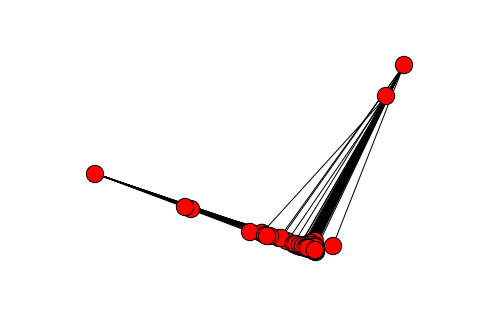

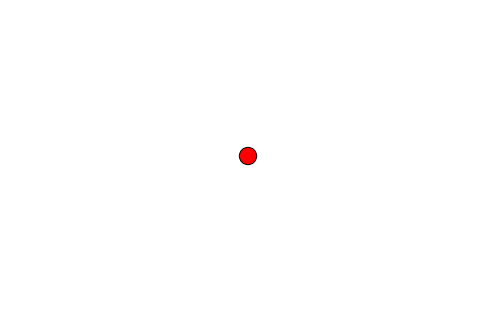

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph(co_citation.values)

components = nx.connected_component_subgraphs(g)
for component in components:
    nx.draw(component, pos=nx.spectral_layout(component))
    plt.show()
    

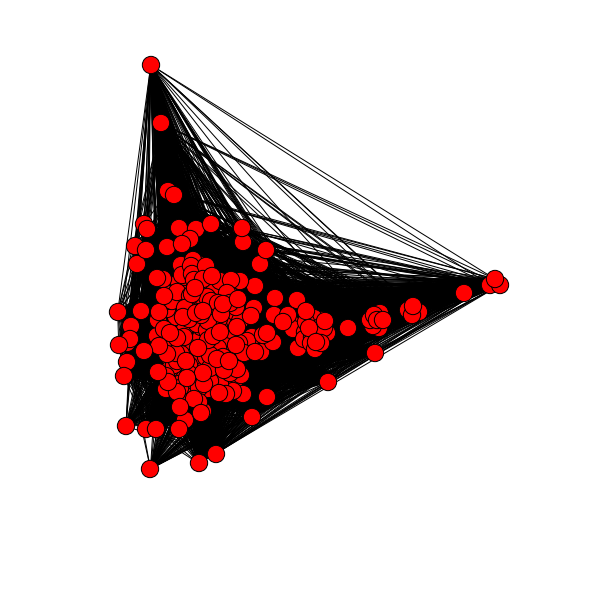

In [21]:
from sklearn import manifold
import matplotlib.pyplot as plt

adjency = co_citation.values

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(adjency)

g = nx.Graph(co_citation.values)
pos = {i: Y[i,:] for i in range(len(g.nodes()))}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

points = nx.draw_networkx_nodes(g, pos=pos, ax=ax)
nx.draw_networkx_edges(g, pos=pos, ax=ax)
ax.set_axis_off()
plt.show()

This nicely cleans up the figure and produces a decent looking visualization of the co-citation network. It would be nice if we could add some interactivity to a graph like this. Since we are using the ipython notebook, it makes sense to benefit from modern day web technology to do so. One library, although still in its infancy, that is easy to use for adding some simple interactivity to figures is mpld3. This library integrates nicely with matplotlib and ipython notebook. 

In [23]:
import mpld3

css="""

h1 {
  font-family:Arial, Helvetica, sans-serif;
  background-color : white;
}

"""

g = nx.Graph(co_citation.values)
pos = {i: Y[i,:] for i in range(len(g.nodes()))}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

points = nx.draw_networkx_nodes(g, pos=pos, ax=ax)
nx.draw_networkx_edges(g, pos=pos, ax=ax)

# here we make the labels and add them to the figure
labels = ["<h1>"+entry+"</h1>" for entry in co_citation.index.values]
tooltip = mpld3.plugins.PointHTMLTooltip(points, labels,
                                   voffset=10, hoffset=10, css=css)
mpld3.plugins.connect(fig, tooltip)

# let's use mpld3 to visualize the figure rather than matplotlib
mpld3.display()

Now that we have the co-citation network as a graph, we can do all kinds of social network analysis on it. 

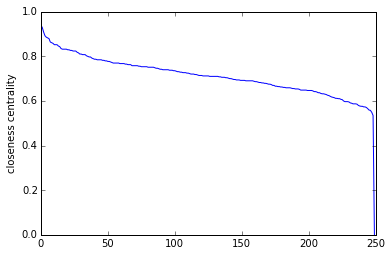

In [24]:
import operator
node_centrality = nx.closeness_centrality(g)
sorted_node_centrality = sorted(node_centrality.items(), 
                                key=operator.itemgetter(1),
                                reverse=True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('closeness centrality')

ax.plot([entry[1] for entry in sorted_node_centrality])
plt.show()



So what are the most central papers in terms of closeness centrality? The network we generated uses id's for the nodes. These match the rows and columns in our dataframe. So we can easily get the name of most central papers.

In [25]:
for node, centrality in sorted_node_centrality[0:10]:
    print(co_citation.columns[node], centrality)

daniel mc;2004 0.9391787683051597
alivisatos ap;1996 0.9285865265573572
iijima s;1991 0.908103000236239
nel a;2006 0.8917112493294477
kroto hw;1985 0.8853190539937527
chan wcw;1998 0.8821572002294893
michalet x;2005 0.8790178507624805
rosi nl;2005 0.8636504058190804
oberdorster g;2005 0.8606411709555993
ferrari m;2005 0.8576528335564481


In [27]:
g1 = next(nx.connected_component_subgraphs(g))

print(nx.average_shortest_path_length(g1))
print(nx.average_clustering(g1))

1.4117761368052857
0.7164260798111189


# Getting affiliation and collaboration data

In this example, we want to produce a collaboration network and visualize this on a map. To do this, we need to know wo collaborates with whom and where each of the authors is located. For this, we can use the C1 field. We need to do some string handling in order to extract from the affiliation information that we can geocode.


In [28]:
import re

affil_regexp = re.compile(r'\[(.*?)\]')
rec_affil = {}

def process_affiliations(record):
    affil = record['C1']
    
    if not affil.startswith('['):
        # work arround, we ignore records that 
        # don't provide author specific affiliations
        return {}
    
    elements = re.split(affil_regexp, affil)
    elements = [entry for entry in elements if entry]
    
    author_affil = zip(elements[0::2], elements[1::2])

    author_affiliation_map = collections.defaultdict(list)

    for authors, affiliation in author_affil:
        list_of_authors = authors.split(';')
        list_of_authors = [author.strip() for author in list_of_authors]
        list_of_authors = [author.lower() for author in list_of_authors]

        for author in list_of_authors:
            author_affiliation_map[author].append(affiliation)
    return author_affiliation_map


for key, record in corpus.items():
    rec_affil[key] = process_affiliations(record)



We have now made an overview of all authors and their affiliations. Let's have a look to see if any author has more than one affiliation

In [29]:
multiple_affiliations = []

for key, author_affiliation_map in rec_affil.items():
    for author, affiliations in author_affiliation_map.items():
        if len(affiliations)>1:
               multiple_affiliations.append((author, affiliations))
        
print(multiple_affiliations[0])

('cabrera, carlos r.', [' Univ Puerto Rico, Dept Chem, San Juan, PR 00931 USA; ', ' NASA URC Ctr Adv Nanoscale Mat, San Juan, PR 00931 USA; '])


Above we see the same name being associated with 2 different universities. In this case, we are looking at an author with two affiliations on the same paper. If we look across the entire dataset, we might even more affiliations for an author with the same name. This might be due to shifts from one university to another, or because of several researchers with the same name. A more detailed investigation might be needed to disambiguate such cases

In [30]:
print(multiple_affiliations[2])

('fonseca, jose', [' Univ Puerto Rico, Dept Chem, San Juan, PR 00931 USA; ', ' NASA URC Ctr Adv Nanoscale Mat, San Juan, PR 00931 USA; '])


Above we see another case, here we have the same person where the university affiliation is simply spelled differently. Again, as an analyst we have to make a choice about how to handle this. We can simply use one of the two affiliations, use complex regular expressions to discover the university name and in this way disambiguate, or do a manual inspection. 

One case we have not yet shown is the situation where we have the same person existing under different names in the dataset. We might run across such a case when investigating collaboration patterns

In [31]:
import pandas as pd

# let's count the authors
# because we don't want to index all authors
# also keep a global counter
authors_counters = {}
global_counter = collections.Counter()
global_author_affil_map = collections.defaultdict(list)
for key, record in rec_affil.items():
    authors = record.keys()
    
    counter = collections.Counter()
    
    for author in authors:
        counter[author] += 1
        global_counter[author] += 1
        global_author_affil_map[author] += record[author]
        
    authors_counters[key] = counter

# get the top 250 most frequently  occurring oauthors
top_250 = global_counter.most_common(n=250)
top_250 = collections.Counter(dict(top_250))

# for all records only keep authors in the top 250
indexed_authors = {}
for key, value in authors_counters.items():
    # we can do an intersect on the keys of two
    # dictionaries
    intersect = value & top_250
    indexed_authors[key] = intersect

# turn it into a dataframe
rec_authors = pd.DataFrame.from_dict(indexed_authors, orient='index')
rec_authors.fillna(0, inplace=True)


In [32]:
import numpy as np
author_collaboration = rec_authors.T.dot(rec_authors)
np.fill_diagonal(author_collaboration.values, 0)

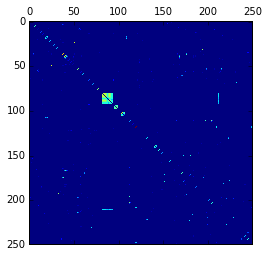

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(author_collaboration.values)
plt.show()

# mapping the data

We have generated a table containing information on collaboration, and an overview of affiliations for each author. The next step is to geocode the affiliations. Once we have geocoded the affiliations, we can show authors on a map

In [34]:
from geopy.geocoders import GoogleV3
import time

geolocator = GoogleV3(timeout=2)
authors_geocode_table = {}

# most geocode API's limit the number of requests
# so we cache all locations to avoid 
# requesting the location using a string we
# have used before
geocode_cache = {}

authors = author_collaboration.columns

for author in authors:
    time.sleep(0.1) # limit the number of requests per second
    affiliations = global_author_affil_map[author]
    affiliation = affiliations[0]
    affiliation = affiliation.split(', ')[-2::]
    affiliation = ', '.join(affiliation)
    
    try:
        location = geocode_cache[affiliation]
    except KeyError:
        location = geolocator.geocode(affiliation)
        
        if location != None:
            location = (location.address, 
                        location.latitude,
                        location.longitude)
        geocode_cache[affiliation] = location
    authors_geocode_table[author] = location


Because the number of queries we can do for free is limited, let's safe the data in json format

In [30]:
import json

with open( r'../../Data/JSON/geocoded authors.json', 'w') as fh:
    json.dump(authors_geocode_table, fh)

# map authors

In [1]:
import json

with open( r'../../Data/JSON/geocoded authors.json', 'r') as fh:
    authors_geocode_table = json.load(fh)


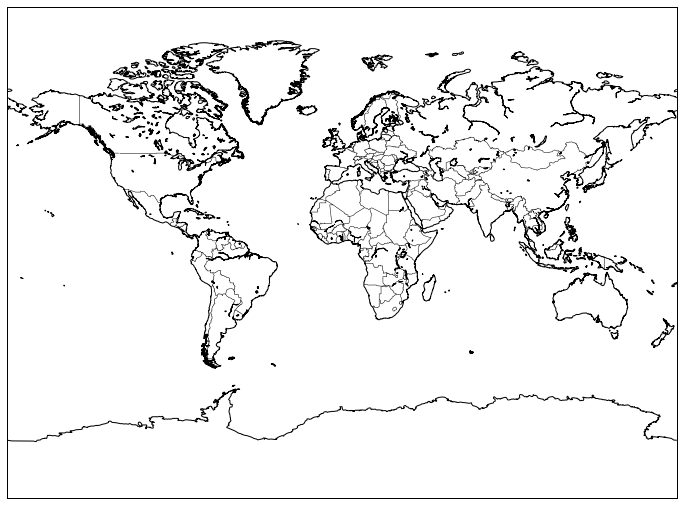

In [7]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

# create new figure, axes instances.
fig = plt.figure(figsize=(12,24))
ax = fig.add_axes()

# setup mill map projection.
m = Basemap(resolution='l',projection='mill')

# draw coastlines and country lines
m.drawcoastlines()
m.drawcountries()

plt.show()

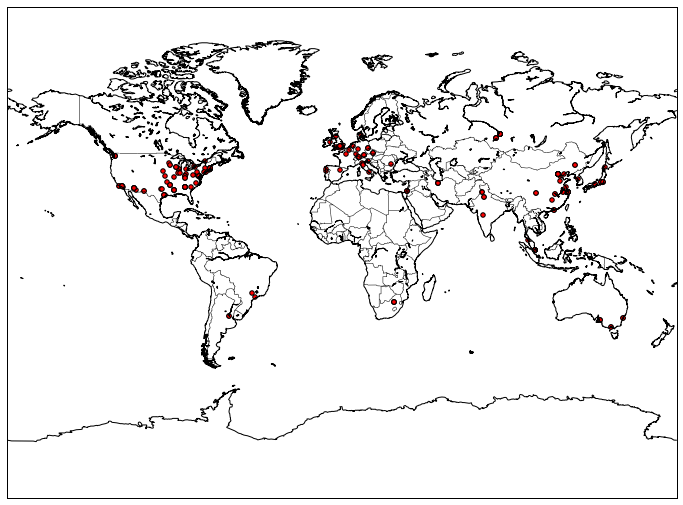

In [8]:
lat = []
lon = []
for location in authors_geocode_table.values():
    if location:
        lat.append(location[1])
        lon.append(location[2])
    
# create new figure, axes instances.
fig = plt.figure(figsize=(12,24))
ax = fig.add_axes()

# setup mill map projection.
m = Basemap(resolution='l',projection='mill')

# draw coastlines and country lines
m.drawcoastlines()
m.drawcountries()

# add authors
# for some reason, scattering all
# points in one go gives an error in 
# basemap. 
for i in range(len(lat)):
    try:
        m.scatter(lon[i], lat[i], latlon=True, c='r')
    except ValueError:
        print(lon[i], lat[i])

plt.show()

# map collaborations

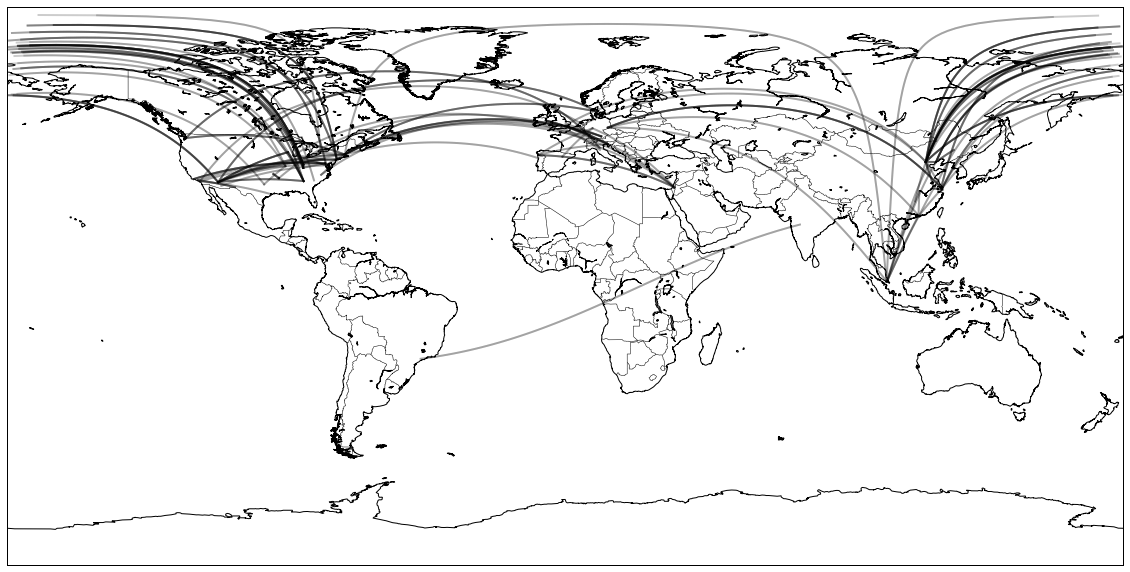

In [49]:
def draw_line(lon_i, lat_i, lon_j, lat_j):
    line, = m.drawgreatcircle(lon_i, lat_i, lon_j, lat_j, c='k', alpha=.2, lw=2)

    # great circle work arround via
    # http://stackoverflow.com/questions/13888566/python-basemap-drawgreatcircle-function

    path = line.get_path()
    
    # find the index which crosses the dateline (the delta is large)
    cut_point = np.where(np.abs(np.diff(path.vertices[:, 0])) > 200)[0]

    if cut_point:
        # create new vertices with a nan inbetween and set those as the path's vertices
        new_verts = np.concatenate(
                                   [path.vertices[:cut_point[0], :], 
                                    [[np.nan, np.nan]], 
                                    path.vertices[cut_point[0]+1:, :]]
                                   )
        path.codes = None
        path.vertices = new_verts
        
        
# create new figure, axes instances.
fig = plt.figure(figsize=(20,24))
ax = fig.add_axes()

# setup mill map projection.
m = Basemap(resolution='l',projection='cyl')

# draw coastlines and country lines
m.drawcoastlines()
m.drawcountries()

# we only want to check the collaborations
# so we need the indices of the non zero
# points in the matrix

authors = author_collaboration.columns
indices = np.argwhere(author_collaboration.values>0)
for index in indices:
    i, j = index
    if i != j: # exclude the diagonal
        author_i = authors[i]
        author_j = authors[j]
        
        try:
            lat_i, lon_i = authors_geocode_table[author_i][1::]
            lat_j, lon_j = authors_geocode_table[author_j][1::]            
            draw_line(lon_i, lat_i, lon_j, lat_j)
        except KeyError:
            # we don't have lat lon data on the author
            pass
        except TypeError:
            # we don't have lat lon data on the author
            pass

plt.show()